In [2]:
!pip install --quiet --upgrade comet_ml
from comet_ml import Experiment
    
# Add the following code anywhere in your machine learning file
experiment = Experiment(api_key="0EKSrlH9OVngYfgQCrauwqLEt",
                        project_name="mri-interpretation", workspace="polina")

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/polina/mri-interpretation/1fec2f0998d4499cba4332899b407805
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (871 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     os packages              : 1
COMET INFO: ---------------------------
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/polina/mri-interpretation/a3e530977dca409daebcc6962f52aa56



In [3]:
import numpy as np
import functools
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import torch.nn.functional as F
from torchsummary import summary
import os
import pathlib
from sklearn.model_selection import train_test_split, StratifiedKFold
import torchio
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.transforms import *
import random
%matplotlib inline

If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Credits instructions: https://torchio.readthedocs.io/#credits



In [4]:
import nilearn
from nilearn import plotting

In [5]:
from data import HCP_MRI

In [6]:
 torch.cuda.is_available()

True

In [7]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")

In [1]:
!nvidia-smi

Wed Dec  2 09:27:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   30C    P0    33W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:89:00.0 Off |                    0 |
| N/A   29C    P0    32W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

# Data

In [8]:
data_dir = pathlib.Path('/home/datasets/adni')

In [9]:
# PATH_TO_MRI = '/home/datasets/HCP_T1'
# behavioral_data = pd.read_csv(data_dir / 'unrestricted_hcp_freesurfer.csv')
# y_id = []
# for file_name in os.listdir(PATH_TO_MRI):
#     if '.nii' in file_name:
#         y_id.append(int(file_name[:6]))
# available_id = pd.DataFrame()
# available_id['id'] = y_id
# behavioral_data.set_index('Subject',inplace=True)
# y_gender = []
# for i in available_id['id']:
#     y_gender.append(behavioral_data['Gender'][i])
# available_id['Gender'] = y_gender
# y = pd.get_dummies(available_id, columns=['Gender'])['Gender_M'].values #F=0,M=1
# # np.save('/home/datasets/adni/labels', y)
# y.shape

In [10]:
# transform = CropOrPad(
#      (180, 180, 180))
# imgs = []
# for i, idd in enumerate(available_id['id']):
#     dir = PATH_TO_MRI
#     file= '{}.nii'.format(idd)
#     full_path=os.path.join(dir,file)
# #     img = nilearn.image.load_img(full_path)
#     img = torchio.Image(full_path, torchio.INTENSITY).data
#     img_crop = transform(img)
#     imgs.append(img_crop)
# #     imgs.append(nilearn.image.get_data(img))
#     if i%25 == 0:
#         print('{} iteration is finished.'.format(i))
        
# X = np.stack(imgs,axis=0)
# # np.savez_compressed('/home/datasets/adni/tensors_cut', X)
# # np.save('/home/datasets/adni/tensors', X)
# del imgs #deleting for freeing space on disc
# X.shape

In [11]:
# #for all 1113 subjects 
# PATH_TO_MRI = '/home/datasets/HCP_T1'
# behavioral_data = pd.read_csv(data_dir / 'unrestricted_hcp_freesurfer.csv')
# y_id = []
# for sub in os.listdir(PATH_TO_MRI):
#     if len(sub) == 6:
#         y_id.append(int(sub))
# available_id = pd.DataFrame()
# available_id['id'] = y_id
# behavioral_data.set_index('Subject',inplace=True)
# y_gender = []
# for i in available_id['id']:
#     y_gender.append(behavioral_data['Gender'][i])
# available_id['Gender'] = y_gender
# y = pd.get_dummies(available_id, columns=['Gender'])['Gender_M'].values #F=0,M=1
# # np.save('/home/datasets/adni/labels_all_data_MPR1', y)
# y.shape

In [12]:
#for all 1113 sub
# transform = CropOrPad(
#      (230, 230, 295))
# imgs = []
# for i, idd in enumerate(available_id['id']):
#     dir = PATH_TO_MRI
#     if i> 700:
#         if os.path.exists('{}/{}/unprocessed/3T/T1w_MPR1/{}_3T_T1w_MPR1.nii.gz'.format(PATH_TO_MRI, idd, idd)):
#             full_path = '{}/{}/unprocessed/3T/T1w_MPR1/{}_3T_T1w_MPR1.nii.gz'.format(PATH_TO_MRI, idd, idd)
#     #     file= '{}.nii'.format(idd)
#     #     full_path=os.path.join(dir,file)
#     #     img = nilearn.image.load_img(full_path)
#         img = torchio.Image(full_path, torchio.INTENSITY).data
#         img_crop = transform(img)
#         imgs.append(img_crop)
#     #     imgs.append(nilearn.image.get_data(img))
#         if i%25 == 0:
#             print('{} iteration is finished.'.format(i))
        
# print(len(imgs))
# print(imgs[0].shape)
# X = np.stack(imgs,axis=0)
# np.savez_compressed('/home/datasets/adni/tensors_cut_all_data_MPR1_1000', X)
# # # np.save('/home/datasets/adni/tensors', X)
# del imgs #deleting for freeing space on disc
# X.shape

In [13]:
# imgs[0].shape

In [14]:
# ex2 = np.load('/home/datasets/adni/tensors_cut_all_data_MPR1_700.npz')
# ex2 = ex2.f.arr_0

In [15]:
# ex = np.load('/home/datasets/adni/tensors_cut_all_data_MPR1_1000.npz')
# ex = ex.f.arr_0

In [16]:
# x = list(ex1,ex2,ex)
# x = np.stack(x, axis=0)
# x.shape

In [17]:
# ex = ex.f.arr_0
# ex.shape

In [9]:
def plot_central_cuts(img, title="", t=None):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    param image: tensor or np array of shape (TxCxDxHxW) if t is not None
    """
    if t is not None:
        img = img[t]
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 6, 6))
    fig.suptitle(title)
    axes[0].imshow(img[0, img.shape[1] // 2, :, :])
    axes[1].imshow(img[0, :, img.shape[2] // 2, :])
    axes[2].imshow(img[0, :, :, img.shape[3] // 2])
    plt.show()
# plot_central_cuts(nilearn.image.get_data(img)[np.newaxis,:], title="ex", t = None)
# plot_central_cuts(img_crop, title="ex", t = None)

In [10]:
PATH_TO_MRI = '/home/datasets/HCP_T1'
data_dir = pathlib.Path('/home/datasets/adni')
behavioral_path = os.path.join(data_dir / 'unrestricted_hcp_freesurfer.csv')
hcp_type = 'MPR1'

In [11]:
def get_absmax(dataset):
    absmax = 0.
    for (img, target) in dataset:
        img = torch.FloatTensor(img).to(device)
        absmax = max(absmax, img.abs().max().item())
        del img, target
    return absmax

def AbsMaxScale(img, absmax):
    return img / absmax

HCP absmax before normalization: 435.0126647949219
Dataset size: 1112
Labels distribution: (array([0, 1]), array([605, 507]))

Example:
Image shape: torch.Size([1, 206, 250, 220])
Type: <class 'torch.Tensor'>
Target: 1


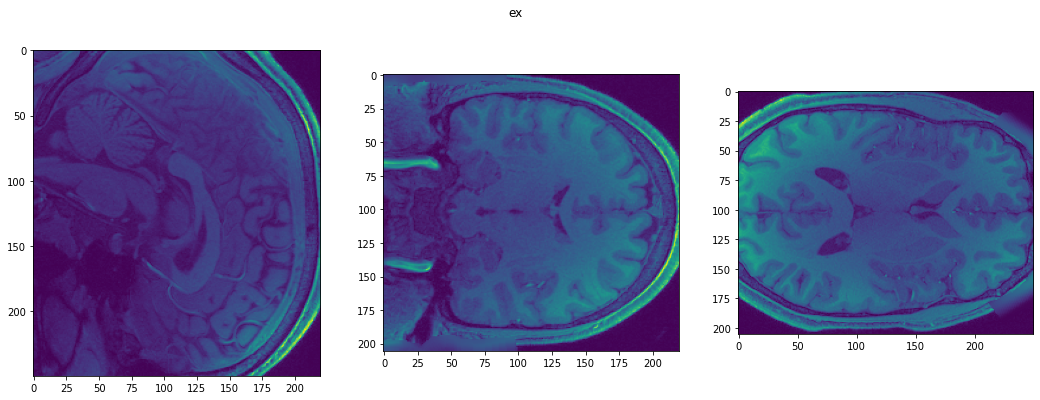

In [12]:
hcp_dataset = HCP_MRI(
    paths= PATH_TO_MRI,
    target_path= behavioral_path,
    load_online=True,
    hcp_type = hcp_type,
    coord_min=(25,30,50),
    img_shape=(206, 250, 220)
)
hcp_absmax = 435.0126647949219 # get_absmax(la5_dataset)
hcp_dataset.transform = functools.partial(AbsMaxScale, absmax=hcp_absmax)

transform = Compose([
#     BrightnessContrast(),
#     GaussNoise(),
#     Rotate(),
    ToTensor(),
])
hcp_dataset.transform = transform
print("HCP absmax before normalization: {}".format(hcp_absmax))
print("Dataset size: {}".format(len(hcp_dataset)))
print("Labels distribution: {}\n".format(np.unique(hcp_dataset.labels, return_counts=True)))

print("Example:")
img, target = hcp_dataset[0]
print("Image shape: {}".format(img.shape))
print("Type: {}".format(type(img)))
print("Target: {}".format(target))
plot_central_cuts(img, title="ex", t = None)

In [12]:
# X_1 = np.load('/home/datasets/adni/tensors_cut_all_data_MPR1_to400.npz')
# y = np.load('/home/datasets/adni/labels_all_data_MPR1.npy')

In [13]:
# random.shuffle(y)

In [14]:
# X = X.f.arr_0

In [13]:

# # X = X[:, np.newaxis, :, :, :]
# print(X.shape, y.shape)

(517, 1, 180, 180, 180) (517,)


In [11]:
# class MriData(torch.utils.data.Dataset):
#     def __init__(self, X, y, transform):
#         super(MriData, self).__init__()
#         self.X = torch.tensor(X, dtype=torch.float32)
#         self.y = torch.tensor(y).long()
#         self.transform = transform
    
#     def __len__(self):
#         return self.X.shape[0]
    
#     def __getitem__(self, idx):
# #         sample = {'img': self.X[idx], 'landmarks': self.y[idx]}
# #         if self.transform:
# #                    sample = self.transform(sample)
#         return self.X[idx], self.y[idx]

# Model structure

In [14]:
## Hidden layers 1, 2 and 3
hidden = lambda c_in, c_out: nn.Sequential(
    nn.Conv3d(c_in, c_out, (3,3,3)), # Convolutional layer
    nn.BatchNorm3d(c_out), # Batch Normalization layer
    nn.ReLU(), # Activational layer
    nn.MaxPool3d(3) # Pooling layer
)

class MriNet(nn.Module):
    def __init__(self, c):
        super(MriNet, self).__init__()
        self.hidden1 = hidden(1, c)
        self.hidden2 = hidden(c, 2*c)
        self.hidden3 = hidden(2*c, 4*c)
        self.hidden4 = hidden(4*c, 4*c)
        self.linear = nn.Linear(256, 2)#16000
#         self.linear = nn.Linear(128*5*5*5, 2)#16000
        self.flatten = nn.Flatten()

    def forward(self, x):
#         print(x.shape)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.hidden4(x)
#         print(x.shape)
        x = self.flatten(x)
        x = self.linear(x)
        
        x = F.log_softmax(x, dim=1)
        return x

torch.manual_seed(1)
np.random.seed(1)

c = 32
model = MriNet(c)

In [16]:
if torch.cuda.device_count() > 1:
      d_ids= [0,1,2,3]
      print("Let's use", d_ids, "GPUs!")
      # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
      model = nn.DataParallel(model, device_ids=d_ids)

model.to(device)

Let's use [0, 1, 2, 3] GPUs!


DataParallel(
  (module): MriNet(
    (hidden1): Sequential(
      (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    )
    (hidden2): Sequential(
      (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    )
    (hidden3): Sequential(
      (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    )
    (hidden4): Sequential(
      (0): Conv3d(128, 128, kernel_size=(3, 3, 3), st

In [15]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42) 
# # transform = CropOrPad(
# #      (180, 180, 180))
# train_dataset = MriData(X_train, y_train, transform=None)
# test_dataset = MriData(X_test, y_test, transform=None)
# del X_train, X_test, y_train, y_test #deleting for freeing space on disc

In [15]:
def stratified_batch_indices(indices, labels):
    dominating_label = stats.mode(labels)[0][0]
    idx0 = indices[labels == dominating_label]
    idx1 = indices[labels != dominating_label]
    step = np.ceil(len(idx0) / len(idx1)) + 1
    assert step >= 1.
    result = []
    j0 = 0
    j1 = 0
    for i in range(len(indices)):
        if (i % step == 0 or j0 == len(idx0)) and j1 < len(idx1):
            result.append(idx1[j1])
            j1 += 1
        else:
            result.append(idx0[j0])
            j0 += 1
    result = np.array(result)
    assert len(result) == len(indices)
    return result

In [13]:
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True)#was 5  #45 - recommended value for batchsize
# val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=False) 
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# cv_splits = list(cv.split(X=np.arange(len(hcp_dataset)), y=hcp_dataset.labels))
# print(len(cv_splits))  
# for i in cv_splits:
#     train_idx, val_idx = cv_splits[i]

#     train_idx = stratified_batch_indices(train_idx, hcp_dataset.labels.iloc[train_idx])
#     train_loader = DataLoader(Subset(hcp_dataset, train_idx),
#                                           shuffle=True,
#                                           batch_size=10)
#     val_loader = DataLoader(Subset(hcp_dataset, val_idx),
#                                     shuffle=False,
#                                     batch_size=10)
X_train_ind, X_test_ind, y_train_ind, y_test_ind = train_test_split(np.arange(len(hcp_dataset)), hcp_dataset.labels, test_size=0.2, stratify=hcp_dataset.labels, random_state=42)
train_loader = torch_data.DataLoader(torch_data.Subset(hcp_dataset, X_train_ind),
                                          shuffle=True,
                                          batch_size=4)
val_loader = torch_data.DataLoader(torch_data.Subset(hcp_dataset, X_test_ind),
                                    shuffle=False,
                                    batch_size=2)

In [14]:
CHECKPOINTS_DIR =  '/home/Druzhinina/project/checkpoints_full/'

In [17]:
criterion = nn.NLLLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005) #return ADAM?
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15], gamma=0.1)

NameError: name 'model' is not defined

In [17]:
model_name = 'default_all_subjects'

In [20]:
# timing
from tqdm import tqdm

def get_accuracy(net, data_loader):
    net.eval()
    correct = 0
    for data, target in tqdm(data_loader):
        data = data.to(device,dtype=torch.float)
        target = target.to(device)

        out = net(data)
        pred = out.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
        del data, target
    accuracy = 100. * correct / len(data_loader.dataset)
    return accuracy.item()

def get_loss(net, data_loader):
    net.eval()
    loss = 0 
    for data, target in tqdm(data_loader):
        data = data.to(device, dtype=torch.float)
        target = target.to(device)
    
        out = net(data)
        loss += criterion(out, target).item()*len(data)

        del data, target, out 

    return loss / len(data_loader.dataset)


def train(epochs, net, criterion, optimizer, train_loader, val_loader, scheduler=None, verbose=True, save=False, experiment= False):
    best_val_loss = 100000 #100_000
    best_val_acc = 0
    best_model = None
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []

    train_loss_list.append(get_loss(net, train_loader))
    val_loss_list.append(get_loss(net, val_loader))
    train_acc_list.append(get_accuracy(net, train_loader))
    val_acc_list.append(get_accuracy(net, val_loader))
    if verbose:
        print('Epoch {:02d}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(0, epochs, train_loss_list[-1], val_loss_list[-1]))

    net.to(device)
    for epoch in tqdm(range(1, epochs+1)):
        net.train()
        for X, y in tqdm(train_loader):
            # Perform one step of minibatch stochastic gradient descent
            X, y = X.to(device, dtype=torch.float), y.to(device)
            optimizer.zero_grad()
#             print(type(X))
            out = net(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            del X, y, out, loss #freeing gpu space
            
        
        # define NN evaluation, i.e. turn off dropouts, batchnorms, etc.
        net.eval()
        for X, y in tqdm(val_loader):
            # Compute the validation loss
            X, y = X.to(device, dtype=torch.float), y.to(device)
            out = net(X)
            del X, y, out #freeing gpu space
         
        train_loss_list.append(get_loss(net, train_loader))
        val_loss_list.append(get_loss(net, val_loader))
        train_acc_list.append(get_accuracy(net, train_loader))
        val_acc_list.append(get_accuracy(net, val_loader))
        
        if scheduler is not None:
            scheduler.step(val_acc_list[-1])

        if save and val_acc_list[-1] > best_val_acc:
            torch.save(net.state_dict(), CHECKPOINTS_DIR + 'best_acc_model_' + model_name)    
            best_val_acc = val_acc_list[-1]
            
        if save and val_loss_list[-1] < best_val_loss:
            torch.save(net.state_dict(), CHECKPOINTS_DIR + 'best_val_loss_model_' + model_name)
            best_val_loss = val_loss_list[-1]
            
        if save and epoch%10==0:
            torch.save(net.state_dict(), CHECKPOINTS_DIR + str(epoch) + '_epoch_model_' + model_name)
            
        freq = 1
        if verbose and epoch%freq==0:
            print('Epoch {:02d}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(epoch, epochs, train_loss_list[-1], val_loss_list[-1]))
        if experiment:
                experiment.log_metric("train_loss", train_loss_list[-1])
                experiment.log_metric("validate_loss", val_loss_list[-1])
                experiment.log_metric("train_acc", train_acc_list[-1])
                experiment.log_metric("validate_acc", val_acc_list[-1])
                experiment.log_epoch_end(epoch)
    return train_loss_list, val_loss_list, train_acc_list, val_acc_list    

In [21]:
experiment.set_name("3DCNN_all_subject_baseline_Adam_5e-5_sch_05_2")

In [23]:
model_name = '_all_subject_adam-4_sch'
experiment.set_name("3DCNN_all_subject_baseline_Adam_5e-5_sch_05_2")

In [33]:
torch.manual_seed(1)
np.random.seed(1)
EPOCHS = 40

train_loss_list, val_loss_list, train_acc_list, val_acc_list = train(EPOCHS, model, criterion, optimizer, train_loader, val_loader, scheduler=scheduler, save=True, experiment= experiment) 

RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/nn/parallel/parallel_apply.py", line 60, in _worker
    output = module(*input, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py", line 550, in __call__
    result = self.forward(*input, **kwargs)
  File "<ipython-input-26-10bbc67a09e3>", line 32, in forward
    x = self.features(x)
  File "/usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py", line 550, in __call__
    result = self.forward(*input, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py", line 100, in forward
    input = module(input)
  File "/usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py", line 550, in __call__
    result = self.forward(*input, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/torch/nn/modules/conv.py", line 481, in forward
    self.padding, self.dilation, self.groups)
RuntimeError: CUDA out of memory. Tried to allocate 3.95 GiB (GPU 0; 15.90 GiB total capacity; 13.98 GiB already allocated; 1.19 GiB free; 13.99 GiB reserved in total by PyTorch)


In [26]:
torch.cuda.empty_cache()

In [ ]:
plt.figure(figsize=(20,8))

plt.subplot(1, 2, 1)
plt.title('Loss history', fontsize=18)
plt.plot(train_loss_list[1:], label='Train')
plt.plot(val_loss_list[1:], label='Validation')
plt.xlabel('# of epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=16)
plt.grid()

plt.subplot(1, 2, 2)
plt.title('Accuracy history', fontsize=18)
plt.plot(train_acc_list, label='Train')
plt.plot(val_acc_list, label='Validation')
plt.xlabel('# of epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=16)
plt.grid()

In [34]:
model.load_state_dict(torch.load(CHECKPOINTS_DIR+'best_model_lr'))
model.eval()

DataParallel(
  (module): MriNet(
    (hidden1): Sequential(
      (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    )
    (hidden2): Sequential(
      (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    )
    (hidden3): Sequential(
      (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    )
    (hidden4): Sequential(
      (0): Conv3d(128, 128, kernel_size=(3, 3, 3), st

In [35]:
get_accuracy(model, val_loader)

90.38461303710938

In [23]:
!ls /home/Druzhinina/project/checkpoints/

ls: cannot access '/home/Druzhinina/project/checkpoints/': No such file or directory


In [15]:
model_name = 'NetGradRandomiz_all_subject_bs42'
experiment.set_name("NetGrad_all_subject_Randomiz_Adam_5e-5_sch_05_2_bs42")

In [16]:
class MriNetGrad(nn.Module):
    def __init__(self, c):
        super(MriNetGrad, self).__init__()
        self.features = nn.Sequential( 
                nn.Conv3d(1, c, kernel_size=3),
                nn.BatchNorm3d(c),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=3),
                
                nn.Conv3d(c, 2*c, kernel_size=3),
                nn.BatchNorm3d(2*c),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=3),
                
                nn.Conv3d(2*c, 4*c, kernel_size=3, stride=1, dilation=1, padding=0),
                nn.BatchNorm3d(4*c),
                nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.MaxPool3d(kernel_size=3),
            nn.Flatten(),
#             nn.Linear(in_features=4*c*5*5*5, out_features=2),
            nn.Linear(in_features=43008, out_features=2)
        )
        self.gradients = None
        
  
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features(x)
        h = x.register_hook(self.activations_hook)
        x = self.classifier(x)
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features(x)
    
torch.manual_seed(1)
np.random.seed(1)

c = 32
model = MriNetGrad(c)

In [17]:
if torch.cuda.device_count() > 1:
      d_ids= [0,1,2,3]
      print("Let's use", d_ids, "GPUs!")
      # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
      model = nn.DataParallel(model, device_ids=d_ids)

model.to(device)

Let's use [0, 1, 2, 3] GPUs!


DataParallel(
  (module): MriNetGrad(
    (features): Sequential(
      (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      (4): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (5): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      (8): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (9): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
    )
    (classifier): Sequential(
      (0): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      (1): Flatten()
      (2): Linear(in_features=43008, out_features=2, bias=True)
    )
  )
)

In [18]:
# model = MriNetGrad(C).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 25], gamma=0.3)
criterion = nn.CrossEntropyLoss()

# criterion = nn.NLLLoss().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0005) #return ADAM?
# scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15], gamma=0.1)

In [21]:
torch.manual_seed(1)
np.random.seed(1)
EPOCHS = 40

train_loss_list, val_loss_list, train_acc_list, val_acc_list = train(EPOCHS, model, criterion, optimizer, train_loader, val_loader, scheduler=scheduler, save=True, experiment= experiment) 

  0%|          | 0/223 [00:00<?, ?it/s]

Epoch 00/40 || Loss:  Train 10.9456 | Validation 12.0888



100%|██████████| 223/223 [23:08<00:00,  6.23s/it]

100%|██████████| 112/112 [02:15<00:00,  1.21s/it]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/223 [00:00<?, ?it/s]

Epoch 01/40 || Loss:  Train 0.5780 | Validation 0.5697



100%|██████████| 223/223 [23:05<00:00,  6.21s/it]

  0%|          | 0/223 [00:00<?, ?it/s]

Epoch 02/40 || Loss:  Train 0.2570 | Validation 0.2686



100%|██████████| 223/223 [23:03<00:00,  6.20s/it]

  0%|          | 0/223 [00:00<?, ?it/s]

Epoch 03/40 || Loss:  Train 0.2038 | Validation 0.2072



100%|██████████| 223/223 [23:03<00:00,  6.21s/it]

  0%|          | 0/223 [00:00<?, ?it/s]

Epoch 04/40 || Loss:  Train 0.1173 | Validation 0.1653



100%|██████████| 223/223 [23:03<00:00,  6.20s/it]

  0%|          | 0/223 [00:00<?, ?it/s]

Epoch 05/40 || Loss:  Train 0.1038 | Validation 0.1655



100%|██████████| 223/223 [23:02<00:00,  6.20s/it]

  0%|          | 0/223 [00:00<?, ?it/s]

Epoch 06/40 || Loss:  Train 0.0957 | Validation 0.1378



100%|██████████| 223/223 [23:09<00:00,  6.23s/it]

  0%|          | 0/223 [00:00<?, ?it/s]

Epoch 07/40 || Loss:  Train 0.0869 | Validation 0.1412



100%|██████████| 223/223 [23:02<00:00,  6.20s/it]

  0%|          | 0/223 [00:00<?, ?it/s]

Epoch 08/40 || Loss:  Train 0.1871 | Validation 0.3177



100%|██████████| 223/223 [23:03<00:00,  6.20s/it]

  0%|          | 0/223 [00:00<?, ?it/s]

Epoch 09/40 || Loss:  Train 0.1795 | Validation 0.3109



100%|██████████| 223/223 [23:02<00:00,  6.20s/it]

  0%|          | 0/223 [00:00<?, ?it/s]

Epoch 10/40 || Loss:  Train 0.0738 | Validation 0.1158



100%|██████████| 223/223 [23:05<00:00,  6.21s/it]

  0%|          | 0/223 [00:00<?, ?it/s]

Epoch 11/40 || Loss:  Train 0.0770 | Validation 0.1537



100%|██████████| 223/223 [23:02<00:00,  6.20s/it]

  0%|          | 0/223 [00:00<?, ?it/s]

Epoch 12/40 || Loss:  Train 0.0946 | Validation 0.1352



100%|██████████| 223/223 [23:02<00:00,  6.20s/it]

  0%|          | 0/223 [00:00<?, ?it/s]

Epoch 13/40 || Loss:  Train 0.0430 | Validation 0.1188



100%|██████████| 223/223 [23:03<00:00,  6.20s/it]

  0%|          | 0/223 [00:00<?, ?it/s]

Epoch 14/40 || Loss:  Train 0.0461 | Validation 0.1265



100%|██████████| 223/223 [23:02<00:00,  6.20s/it]

  0%|          | 0/223 [00:00<?, ?it/s]

Epoch 15/40 || Loss:  Train 0.0520 | Validation 0.1528



100%|██████████| 223/223 [23:02<00:00,  6.20s/it]

  0%|          | 0/223 [00:00<?, ?it/s]

Epoch 16/40 || Loss:  Train 0.0380 | Validation 0.1067



100%|██████████| 223/223 [23:07<00:00,  6.22s/it]

  0%|          | 0/223 [00:00<?, ?it/s]

Epoch 17/40 || Loss:  Train 0.0490 | Validation 0.0980



100%|██████████| 223/223 [23:02<00:00,  6.20s/it]

  0%|          | 0/223 [00:00<?, ?it/s]

Epoch 18/40 || Loss:  Train 0.0323 | Validation 0.0911



100%|██████████| 223/223 [23:03<00:00,  6.20s/it]

  0%|          | 0/223 [00:00<?, ?it/s]

Epoch 19/40 || Loss:  Train 0.0302 | Validation 0.1119



100%|██████████| 223/223 [23:00<00:00,  6.19s/it]

  0%|          | 0/223 [00:00<?, ?it/s]

Epoch 20/40 || Loss:  Train 0.0327 | Validation 0.0919



100%|██████████| 223/223 [23:06<00:00,  6.22s/it]

  0%|          | 0/223 [00:00<?, ?it/s]

Epoch 21/40 || Loss:  Train 0.0339 | Validation 0.0901



100%|██████████| 223/223 [23:01<00:00,  6.20s/it]

  0%|          | 0/223 [00:00<?, ?it/s]

Epoch 22/40 || Loss:  Train 0.0333 | Validation 0.1319



100%|██████████| 223/223 [23:01<00:00,  6.19s/it]

  0%|          | 0/223 [00:00<?, ?it/s]

Epoch 23/40 || Loss:  Train 0.0616 | Validation 0.1991



100%|██████████| 223/223 [23:04<00:00,  6.21s/it]

  0%|          | 0/223 [00:00<?, ?it/s]

Epoch 24/40 || Loss:  Train 0.0336 | Validation 0.1396



100%|██████████| 223/223 [23:04<00:00,  6.21s/it]

  0%|          | 0/223 [00:00<?, ?it/s]

Epoch 25/40 || Loss:  Train 0.0220 | Validation 0.0940



100%|██████████| 223/223 [23:03<00:00,  6.21s/it]

  0%|          | 0/223 [00:00<?, ?it/s]

Epoch 26/40 || Loss:  Train 0.0217 | Validation 0.0961



100%|██████████| 223/223 [23:08<00:00,  6.23s/it]

  0%|          | 0/223 [00:00<?, ?it/s]

Epoch 27/40 || Loss:  Train 0.0222 | Validation 0.1175



100%|██████████| 223/223 [23:01<00:00,  6.20s/it]

  0%|          | 0/223 [00:00<?, ?it/s]

Epoch 28/40 || Loss:  Train 0.0281 | Validation 0.1489



100%|██████████| 223/223 [23:02<00:00,  6.20s/it]

  0%|          | 0/223 [00:00<?, ?it/s]

Epoch 29/40 || Loss:  Train 0.0185 | Validation 0.1021



100%|██████████| 223/223 [23:02<00:00,  6.20s/it]

  0%|          | 0/223 [00:00<?, ?it/s]

Epoch 30/40 || Loss:  Train 0.0185 | Validation 0.0904



100%|██████████| 223/223 [23:03<00:00,  6.20s/it]

  0%|          | 0/223 [00:00<?, ?it/s]

Epoch 31/40 || Loss:  Train 0.0164 | Validation 0.0898



100%|██████████| 223/223 [23:01<00:00,  6.20s/it]

  0%|          | 0/223 [00:00<?, ?it/s]

Epoch 32/40 || Loss:  Train 0.0151 | Validation 0.0943



100%|██████████| 223/223 [23:01<00:00,  6.19s/it]

  0%|          | 0/223 [00:00<?, ?it/s]

Epoch 33/40 || Loss:  Train 0.0121 | Validation 0.0903



100%|██████████| 223/223 [23:01<00:00,  6.19s/it]

  0%|          | 0/223 [00:00<?, ?it/s]

Epoch 34/40 || Loss:  Train 0.0142 | Validation 0.0808



100%|██████████| 223/223 [23:01<00:00,  6.19s/it]

  0%|          | 0/223 [00:00<?, ?it/s]

Epoch 35/40 || Loss:  Train 0.0139 | Validation 0.0901



100%|██████████| 223/223 [23:01<00:00,  6.19s/it]

  0%|          | 0/223 [00:00<?, ?it/s]

Epoch 36/40 || Loss:  Train 0.0113 | Validation 0.0921



100%|██████████| 223/223 [23:06<00:00,  6.22s/it]

  0%|          | 0/223 [00:00<?, ?it/s]

Epoch 37/40 || Loss:  Train 0.0176 | Validation 0.1295



100%|██████████| 223/223 [23:01<00:00,  6.19s/it]

  0%|          | 0/223 [00:00<?, ?it/s]

Epoch 38/40 || Loss:  Train 0.0104 | Validation 0.0845



100%|██████████| 223/223 [23:01<00:00,  6.19s/it]

  0%|          | 0/223 [00:00<?, ?it/s]

Epoch 39/40 || Loss:  Train 0.0117 | Validation 0.0888



100%|██████████| 223/223 [23:00<00:00,  6.19s/it]

100%|██████████| 40/40 [30:55:39<00:00, 2783.49s/it]

Epoch 40/40 || Loss:  Train 0.0110 | Validation 0.0975


In [22]:
get_accuracy(model, val_loader)

96.8609848022461

In [22]:
np.save('/home/mri/datasets/adni/y_randomize', y)

In [25]:
model.load_state_dict(torch.load('/home/Druzhinina/project/checkpoints_full/best_acc_model_NetGradRandomiz_all_subject_bs42'))
model.eval()

DataParallel(
  (module): MriNetGrad(
    (features): Sequential(
      (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      (4): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (5): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      (8): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (9): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
    )
    (classifier): Sequential(
      (0): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      (1): Flatten()
      (2): Linear(in_features=43008, out_features=2, bias=True)
    )
  )
)

In [26]:
get_accuracy(model, val_loader)

98.2062759399414

In [28]:
model.load_state_dict(torch.load('/home/Druzhinina/project/checkpoints_full/best_val_loss_model_NetGradRandomiz_all_subject_bs42'))
model.eval()

DataParallel(
  (module): MriNetGrad(
    (features): Sequential(
      (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      (4): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (5): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      (8): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (9): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
    )
    (classifier): Sequential(
      (0): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      (1): Flatten()
      (2): Linear(in_features=43008, out_features=2, bias=True)
    )
  )
)

In [29]:
get_accuracy(model, val_loader)

98.2062759399414